In [1]:
import os
import random
import warnings
from prophet.plot import add_changepoints_to_plot, plot_seasonality
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import koreanize_matplotlib
# from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
# import logging
# logging.getLogger('Prophet').setLevel(logging.ERROR)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
warnings.filterwarnings(action='ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)  # Seed 고정

In [3]:
building_df = pd.read_csv('./building_info.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [5]:

building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].replace('-', 0).astype(float)
building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].replace('-', 0).astype(float)
building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].replace('-', 0).astype(float)
train_df = train_df.merge(building_df, on="건물번호", how="left")
test_df = test_df.merge(building_df, on="건물번호", how="left")
train_df.rename(columns={"num_date_time" : "num_date_time", "건물번호":"b_num", "일시" : "D&T", "기온(C)" : "temp", "강수량(mm)" : "precip", "풍속(m/s)" : "w_s" , "습도(%)" : "hum", "일조(hr)" : "일조(hr)", "일사(MJ/m2)" : "일사(MJ/m2)", "전력소비량(kWh)":"power", "건물유형":"b_type", "연면적(m2)":"f_area", "냉방면적(m2)":"c_area", "태양광용량(kW)": "SUN_light", "ESS저장용량(kWh)": "ESS_save", "PCS용량(kW)":"PCS" }, inplace=True)
test_df.rename(columns={"num_date_time" : "num_date_time", "건물번호":"b_num", "일시" : "D&T", "기온(C)" : "temp", "강수량(mm)" : "precip", "풍속(m/s)" : "w_s" , "습도(%)" : "hum", "일조(hr)" : "일조(hr)", "일사(MJ/m2)" : "일사(MJ/m2)", "전력소비량(kWh)":"power", "건물유형":"b_type", "연면적(m2)":"f_area", "냉방면적(m2)":"c_area", "태양광용량(kW)": "SUN_light", "ESS저장용량(kWh)": "ESS_save", "PCS용량(kW)":"PCS"} , inplace= True)
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5:
        return 1
    else:
        return 0
def is_noon(ds):
    date = pd.to_datetime(ds)
    if date.hour >= 7 and date.hour<20:
        return 1
    else:
        return 0    
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
def make_data(train_df):
    # 선형보간 실시
    train_df["w_s"] = train_df["w_s"].interpolate()
    train_df["hum"] = train_df["hum"].interpolate()
    # 소수점 단위 절삭
    train_df["c_area"] = train_df["c_area"].round(4)
    train_df["f_area"] = train_df["f_area"].round(4)
    # 레이블 인코딩
    lf1 = LabelEncoder()
    train_df["c_area"] = lf1.fit_transform(train_df["c_area"])
    lf2= LabelEncoder()
    train_df["f_area"] = lf2.fit_transform(train_df["f_area"])
    lf3 = LabelEncoder()
    train_df["b_type"] = lf3.fit_transform(train_df["b_type"])

    # 파생변수 생성 (train data)
    train_df['D&T'] = pd.to_datetime(train_df['D&T'])
    train_df['hour'] = train_df['D&T'].dt.hour
    train_df['sin_time'] = np.sin(2*np.pi*train_df.hour/24)
    train_df['cos_time'] = np.cos(2*np.pi*train_df.hour/24)
    train_df['day'] = train_df['D&T'].dt.weekday
    train_df['weekend'] = train_df['day'].isin([5,6]).astype(int)
    train_df['month'] = train_df['D&T'].dt.month
    train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['hum']/100)*(9/5*train_df['temp']-26)+32
    train_df['weekend'] = train_df['D&T'].apply(is_weekend)
    train_df['noon'] = train_df['D&T'].apply(is_noon)
    cdhs = np.array([])
    for num in range(1,101,1):
        temp = train_df[train_df['b_num'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    if "power" in train_df.columns:
        train_df['CDH'] = cdhs
        train_df.drop("num_date_time", axis =1 , inplace=True)
        # K-Means > train data
        by_day = train_df.groupby(['b_num','day'])['power'].median().reset_index().pivot('b_num','day','power').reset_index()
        by_hour = train_df.groupby(['b_num','hour'])['power'].median().reset_index().pivot('b_num','hour','power').reset_index().drop('b_num', axis = 1)
        df = pd.concat([by_day, by_hour], axis= 1)
        columns = ['b_num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
        df.columns = columns
        kmeans = KMeans(n_clusters=5, random_state = 42)
        km_cluster = kmeans.fit_predict(df.iloc[:,1:])

        df_clust = df.copy()
        df_clust['km_cluster'] = km_cluster
        # df_clust['km_cluster'] = df_clust['km_cluster'].map({})

        train_df = train_df.merge(df_clust[['b_num','km_cluster']], on='b_num', how='left')
        km_d = pd.get_dummies(train_df['km_cluster'], prefix='km', drop_first=False)

        train_df = pd.concat([train_df, km_d], axis=1)
            # prophet 형태로 전환
        train_df.rename(columns={"D&T": "ds", "power": "y"}, inplace=True)
        train_df = train_df.fillna(0)
        return train_df, df_clust

        
    else : 
        pass

    return train_df

In [7]:
train_df, df_clust= make_data(train_df)
# train_df["c_area"].describe()

In [8]:
test_df = make_data(test_df)
test_df = test_df.merge(df_clust[['b_num','km_cluster']], on='b_num', how='left')
km_d = pd.get_dummies(test_df['km_cluster'], prefix='km', drop_first=False)
# prophet 형태로 전환
train_df.rename(columns={"D&T": "ds", "power": "y"}, inplace=True)
train_df = train_df.fillna(0)
test_df = pd.concat([test_df, km_d], axis=1)

,num_date_time,b_num,D&T,temp,precip,w_s,hum,b_type,f_area,c_area,SUN_light,ESS_save,PCS,hour,sin_time,cos_time,day,weekend,month,THI,noon,km_cluster,km_0,km_1,km_2,km_3,km_4
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,0,59,35,0.0,0.0,0.0,0,0.000000,1.000000,3,0,8,71.78980,0,0,1,0,0,0,0
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,0,59,35,0.0,0.0,0.0,1,0.258819,0.965926,3,0,8,71.02840,0,0,1,0,0,0,0
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,0,59,35,0.0,0.0,0.0,2,0.500000,0.866025,3,0,8,70.81675,0,0,1,0,0,0,0
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,0,59,35,0.0,0.0,0.0,3,0.707107,0.707107,3,0,8,70.11262,0,0,1,0,0,0,0
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,0,59,35,0.0,0.0,0.0,4,0.866025,0.500000,3,0,8,69.56514,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,11,21,37,0.0,0.0,0.0,19,-0.965926,0.258819,2,0,8,71.22400,1,4,0,0,0,0,1
16796,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,11,21,37,0.0,0.0,0.0,20,-0.866025,0.500000,2,0,8,68.95035,0,4,0,0,0,0,1
16797,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,11,21,37,0.0,0.0,0.0,21,-0.707107,0.707107,2,0,8,68.24604,0,4,0,0,0,0,1
16798,100_20220831 22,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,11,21,37,0.0,0.0,0.0,22,-0.500000,0.866025,2,0,8,68.01203,0,4,0,0,0,0,1


## 가장 결과가 좋았던 외생변수 4종을 포함한 코드에 prameter 최적화를 수행한다

In [27]:
test_submission = pd.DataFrame(columns=['num_date_time', 'answer'])

holidays = pd.DataFrame(columns=['holiday', 'ds'])

for i in tqdm(range(1, 101)):
    # 한건물당 168개씩 예측한다
    sample_train = train_df.loc[(train_df["b_num"] == i), ]
    data = sample_train[[i for i in sample_train.columns if i != "일조(hr)" and i != "일사(MJ/m2)"]].reset_index(drop=True)
    sample_test = test_df.loc[(test_df["b_num"] == i), ]
    test_data = sample_test[[i for i in sample_test.columns if i != "일조(hr)" and i != "일사(MJ/m2)"]].reset_index(drop=True)

    m = Prophet(
        # growth: Any = 'linear',
        #      changepoints: Any = None,
        #      n_changepoints: Any = 25,
             changepoint_range = 1, # 5.716236755082271
        #      yearly_seasonality: Any = 'auto',
        #      weekly_seasonality: Any = 'auto',
        #      daily_seasonality = ,
             holidays = holidays,
             # seasonality_mode = 'multiplicative',
             # seasonality_prior_scale = 10,
             holidays_prior_scale =  0.007,# 5.798551926630998
             changepoint_prior_scale = 0.017, # 5.726094850564224
        #      mcmc_samples = 30, # 나중에 다시 고려할 것
        #      interval_width =1,
        #      uncertainty_samples = 500,
        #      stan_backend: Any = None
    )
    '''
km_3          0.380319
km_1          0.311516
km_2          0.094076
noon          0.037508
c_area        0.022234
f_area        0.020095
b_num         0.015524
THI           0.011760
hour          0.011415
cos_time      0.011260
km_4          0.010700
day           0.010540
km_cluster    0.009116
SUN_light     0.008888
km_0          0.008292
sin_time      0.007775
weekend       0.007529
b_type        0.007191
CDH           0.004790
hum           0.001859
month         0.001687
temp          0.001544
w_s           0.001465
일사(MJ/m2)     0.001170
PCS           0.000698
ESS_save      0.000582
일조(hr)        0.000308
precip        0.000159
    '''
    # 계절성 추가
    m.add_seasonality(name='noon', period=7, fourier_order=84, condition_name='noon', prior_scale= 10)  # 3.68932757928076
    m.add_seasonality(name='weekend', period=1, fourier_order=84, condition_name='weekend', prior_scale= 7) # 3.6296482814114484
    
    # 공휴일 추가
    m.add_country_holidays(country_name='KR')
    # 외생변수 추가
    m.add_regressor('km_3')
    m.add_regressor('km_1') 
    m.add_regressor('km_2') # 6.357611052824596
#     m.add_regressor('c_area') # 옵티마이저 오류로 제외처리 -> label encoding 후 5.859738677367077
    m.add_regressor('f_area') # 옵티마이저 오류로 제외처리 -> label encoding 후 5.850376571825546
#     m.add_regressor('b_num') # 6.415231351641329
    m.add_regressor('THI') # 6.195088810269333
    m.add_regressor('hour') # 6.174984244049625
    m.add_regressor('cos_time') # 6.167108209487093
#     m.add_regressor('km_4') # 6.172539921486372
    m.add_regressor('day') # 6.100261553945959
#     m.add_regressor('km_cluster') # 6.104853937505138
#     m.add_regressor('SUN_light') # 6.108987779227074
#     m.add_regressor('km_0') # 6.108479479789926
#     m.add_regressor('sin_time') # 6.104529462878759
    m.add_regressor('b_type') # 5.918354697409236
#     m.add_regressor('CDH') # 5.971034075622254
    m.add_regressor('hum') # 5.90983672736866
    m.add_regressor('month') # 5.861836354704087
    m.add_regressor('temp') # 5.85962412110355
#     m.add_regressor('w_s') # 5.861515129127737
#     m.add_regressor('PCS') # 5.873309323319621
    m.add_regressor('ESS_save') # 5.8560206002232515
#     m.add_regressor('precip') # 5.8582046633179505

    m.fit(data
          # ,show_progress = False
          )
    
    # future에 데이터 삽입
    future = m.make_future_dataframe(periods=168, freq='1H')
    future['km_3'] = data['km_3']
    future['km_1'] = data['km_1']
    future['km_2'] = data['km_2']
    future['noon'] = data['noon'] 
#     future['c_area'] = data['c_area'] 
    future['f_area'] = data['f_area'] 
#     future['b_num'] = data['b_num'] 
    future['THI'] = data['THI'] 
    future['hour'] = data['hour']
    future['cos_time'] = data['cos_time']
#     future['km_4'] = data['km_4'] 
    future['day'] = data['day']
#     future['km_cluster'] = data['km_cluster']
#     future['SUN_light'] = data['SUN_light']
#     future['km_0'] = data['km_0']
#     future['sin_time'] = data['sin_time']
    future['weekend'] = data['weekend']
    future['b_type'] = data['b_type']
#     future['CDH'] = data['CDH']
    future['hum'] = data['hum']
    future['month'] = data['month']
    future['temp'] = data['temp']
#     future['w_s'] = data['w_s']
#     future['PCS'] = data['PCS']
    future['ESS_save'] = data['ESS_save']
#     future['precip'] = data['precip']

#     future.loc[future.shape[0] - 168:, '기온(C)'] = test_data.loc[:, '기온(C)'].values
    # future 예측데이터 row에 데이터 삽입
    future.loc[future.shape[0] - 168:, 'km_3'] = test_data.loc[:, 'km_3'].values
    future.loc[future.shape[0] - 168:, 'km_1'] = test_data.loc[:, 'km_1'].values
    future.loc[future.shape[0] - 168:, 'km_2'] = test_data.loc[:, 'km_2'].values 
    future.loc[future.shape[0] - 168:, 'noon'] = test_data.loc[:, 'noon'].values    
#     future.loc[future.shape[0] - 168:, 'c_area'] = sample_x['c_area'].values 
    future.loc[future.shape[0] - 168:, 'f_area'] = test_data.loc[:, 'f_area'].values
#     future.loc[future.shape[0] - 168:, 'b_num'] = sample_x['b_num'].values 
    future.loc[future.shape[0] - 168:, 'THI'] = test_data.loc[:, 'THI'].values
    future.loc[future.shape[0] - 168:, 'hour'] = test_data.loc[:, 'hour'].values
    future.loc[future.shape[0] - 168:, 'cos_time'] = test_data.loc[:, 'cos_time'].values
#     future.loc[future.shape[0] - 168:, 'km_4'] = sample_x['km_4'].values
    future.loc[future.shape[0] - 168:, 'day'] = test_data.loc[:, 'day'].values
#     future.loc[future.shape[0] - 168:, 'km_cluster'] = sample_x['km_cluster'].values
#     future.loc[future.shape[0] - 168:, 'SUN_light'] = sample_x['SUN_light'].values
#     future.loc[future.shape[0] - 168:, 'km_0'] = sample_x['km_0'].values
#     future.loc[future.shape[0] - 168:, 'sin_time'] = sample_x['sin_time'].values
    future.loc[future.shape[0] - 168:, 'weekend'] = test_data.loc[:, 'weekend'].values
    future.loc[future.shape[0] - 168:, 'b_type'] = test_data.loc[:, 'b_type'].values
#     future.loc[future.shape[0] - 168:, 'CDH'] = sample_x['CDH'].values
    future.loc[future.shape[0] - 168:, 'hum'] = test_data.loc[:, 'hum'].values
    future.loc[future.shape[0] - 168:, 'month'] = test_data.loc[:, 'month'].values
    future.loc[future.shape[0] - 168:, 'temp'] = test_data.loc[:, 'temp'].values
#     future.loc[future.shape[0] - 168:, 'w_s'] = sample_x['w_s'].values
#     future.loc[future.shape[0] - 168:, 'PCS'] = sample_x['PCS'].values
    future.loc[future.shape[0] - 168:, 'ESS_save'] = test_data.loc[:, 'ESS_save'].values
#     future.loc[future.shape[0] - 168:, 'precip'] = sample_x['precip'].values    

    forecast = m.predict(future)

    answer = forecast[-168:].loc[:, ['ds', 'yhat']].rename(
        columns={"ds": "num_date_time", "yhat": "answer"}).reset_index(drop=True)

    answer["year"] = answer["num_date_time"].dt.year.astype(str)
    answer["month"] = answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"] = answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"] = answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_" + answer["year"] + answer["month"] + answer["day"] + ' ' + answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time", "answer"]]
test_submission.set_index("num_date_time", inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

08:50:08 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:12 - cmdstanpy - INFO - Chain [1] start processing
08:50:13 - cmdstanpy - INFO - Chain [1] done processing
08:50:14 - cmdstanpy - INFO - Chain [1] start processing
08:50:16 - cmdstanpy - INFO - Chain [1] done processing
08:50:17 - cmdstanpy - INFO - Chain [1] start processing
08:50:18 - cmdstanpy - INFO - Chain [1] done processing
08:50:20 - cmdstanpy - INFO - Chain [1] start processing
08:50:21 - cmdstanpy - INFO - Chain [1] done processing
08:50:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:50:21 - cmdstanpy - INFO - Chain [1] start processing
08:52:30 - cmdstanpy - INFO - Chain [1] done processing
08:52:31 - cmdstanpy - INFO - Chain [1] start processing
08:52:33 - cmdstanpy - INFO - Chain [1] done processing
08:52:34 - cmdstanpy - INFO - Chain [1] start process

08:56:00 - cmdstanpy - INFO - Chain [1] done processing
08:56:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:56:00 - cmdstanpy - INFO - Chain [1] start processing
08:58:26 - cmdstanpy - INFO - Chain [1] done processing
08:58:28 - cmdstanpy - INFO - Chain [1] start processing
08:58:31 - cmdstanpy - INFO - Chain [1] done processing
08:58:32 - cmdstanpy - INFO - Chain [1] start processing
08:58:34 - cmdstanpy - INFO - Chain [1] done processing
08:58:35 - cmdstanpy - INFO - Chain [1] start processing
08:58:38 - cmdstanpy - INFO - Chain [1] done processing
08:58:39 - cmdstanpy - INFO - Chain [1] start processing
08:58:41 - cmdstanpy - INFO - Chain [1] done processing
08:58:42 - cmdstanpy - INFO - Chain [1] start processing
08:58:44 - cmdstanpy - INFO - Chain [1] done processing
08:58:45 - cmdstanpy - INFO - Chain [1] start processing
08:58:47 - cmdstanpy - INFO - Chain [1] done processi

In [28]:
test_data

,num_date_time,b_num,D&T,temp,precip,w_s,hum,b_type,f_area,c_area,SUN_light,ESS_save,PCS,hour,sin_time,cos_time,day,weekend,month,THI,noon,km_cluster,km_0,km_1,km_2,km_3,km_4
0,100_20220825 00,100,2022-08-25 00:00:00,20.2,0.0,0.0,97,11,21,37,0.0,0.0,0.0,0,0.000000,1.000000,3,0,8,68.18906,0,4,0,0,0,0,1
1,100_20220825 01,100,2022-08-25 01:00:00,19.7,0.0,0.1,99,11,21,37,0.0,0.0,0.0,1,0.258819,0.965926,3,0,8,67.40797,0,4,0,0,0,0,1
2,100_20220825 02,100,2022-08-25 02:00:00,19.4,0.0,0.1,99,11,21,37,0.0,0.0,0.0,2,0.500000,0.866025,3,0,8,66.87094,0,4,0,0,0,0,1
3,100_20220825 03,100,2022-08-25 03:00:00,19.2,0.0,0.0,100,11,21,37,0.0,0.0,0.0,3,0.707107,0.707107,3,0,8,66.56000,0,4,0,0,0,0,1
4,100_20220825 04,100,2022-08-25 04:00:00,19.0,0.0,0.0,100,11,21,37,0.0,0.0,0.0,4,0.866025,0.500000,3,0,8,66.20000,0,4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,11,21,37,0.0,0.0,0.0,19,-0.965926,0.258819,2,0,8,71.22400,1,4,0,0,0,0,1
164,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,11,21,37,0.0,0.0,0.0,20,-0.866025,0.500000,2,0,8,68.95035,0,4,0,0,0,0,1
165,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,11,21,37,0.0,0.0,0.0,21,-0.707107,0.707107,2,0,8,68.24604,0,4,0,0,0,0,1
166,100_20220831 22,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,11,21,37,0.0,0.0,0.0,22,-0.500000,0.866025,2,0,8,68.01203,0,4,0,0,0,0,1


In [29]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Chuseok,Alternative holiday of Chuseok_lower,Alternative holiday of Chuseok_upper,Alternative holiday of Hangeul Day,Alternative holiday of Hangeul Day_lower,Alternative holiday of Hangeul Day_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,ESS_save,ESS_save_lower,ESS_save_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,Liberation Day_upper,Lunar New Year's Day,Lunar New Year's Day_lower,Lunar New Year's Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,THI,THI_lower,THI_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,b_type,b_type_lower,b_type_upper,cos_time,cos_time_lower,cos_time_upper,daily,daily_lower,daily_upper,day,day_lower,day_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,f_area,f_area_lower,f_area_upper,holidays,holidays_lower,holidays_upper,hour,hour_lower,hour_upper,hum,hum_lower,hum_upper,km_1,km_1_lower,km_1_upper,km_2,km_2_lower,km_2_upper,km_3,km_3_lower,km_3_upper,month,month_lower,month_upper,noon,noon_lower,noon_upper,temp,temp_lower,temp_upper,weekend,weekend_lower,weekend_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-06-01 00:00:00,483.235056,143.360593,316.892888,483.235056,483.235056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-40.141194,-40.141194,-40.141194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-248.570093,-248.570093,-248.570093,64.050971,64.050971,64.050971,0.175858,0.175858,0.175858,-337.595217,-337.595217,-337.595217,-4.324033,-4.324033,-4.324033,112.987043,112.987043,112.987043,233.441993,233.441993,233.441993,0.0,0.0,0.0,-8.736364,-8.736364,-8.736364,-2.992403,-2.992403,-2.992403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.20758,-25.20758,-25.20758,0.000000,0.000000,0.000000,-103.280205,-103.280205,-103.280205,0.0,0.0,0.0,-23.961919,-23.961919,-23.961919,0.0,0.0,0.0,234.664963
1,2022-06-01 01:00:00,483.275286,95.738227,259.473355,483.275286,483.275286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-43.093731,-43.093731,-43.093731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-307.807517,-307.807517,-307.807517,64.050971,64.050971,64.050971,0.169865,0.169865,0.169865,-387.962932,-387.962932,-387.962932,-4.324033,-4.324033,-4.324033,104.091641,104.091641,104.091641,233.441993,233.441993,233.441993,0.0,0.0,0.0,-7.976680,-7.976680,-7.976680,-1.705646,-1.705646,-1.705646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.20758,-25.20758,-25.20758,0.000000,0.000000,0.000000,-111.263518,-111.263518,-111.263518,0.0,0.0,0.0,-23.936226,-23.936226,-23.936226,0.0,0.0,0.0,175.467769
2,2022-06-01 02:00:00,483.315515,71.968340,236.712505,483.315515,483.315515,0.0,0.0,0.0,0.0,0.0

In [30]:
m.train_holiday_names

0                                New Year's Day
1                          Lunar New Year's Day
2     The day preceding of Lunar New Year's Day
3        The second day of Lunar New Year's Day
4                     Independence Movement Day
5                        Birthday of the Buddha
6                                Children's Day
7                                    Labour Day
8                                  Memorial Day
9                                Liberation Day
10                                      Chuseok
11                 The day preceding of Chuseok
12                    The second day of Chuseok
13               Alternative holiday of Chuseok
14                      National Foundation Day
15                                  Hangeul Day
16           Alternative holiday of Hangeul Day
17                                Christmas Day
dtype: object

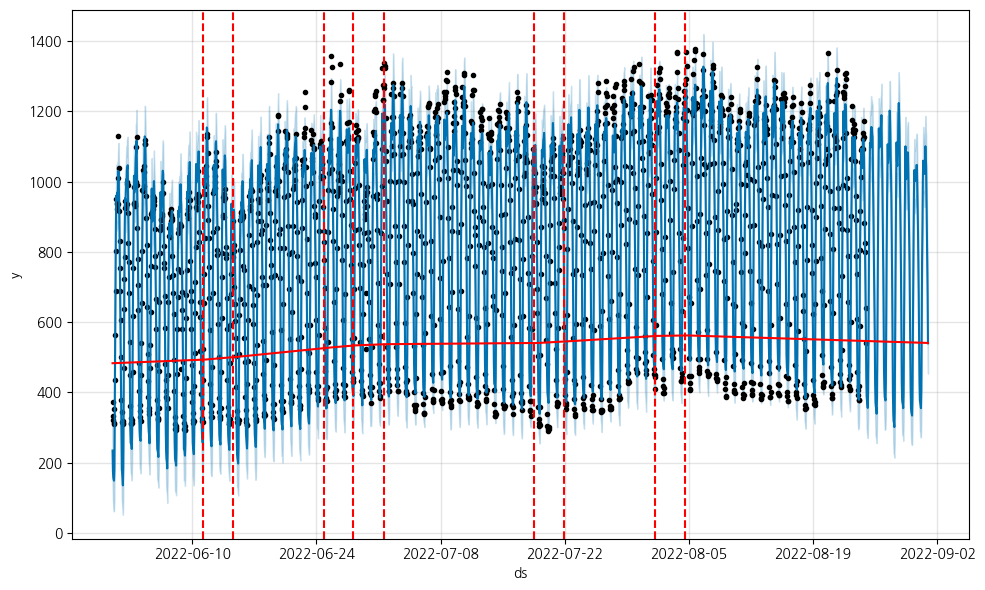

In [31]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

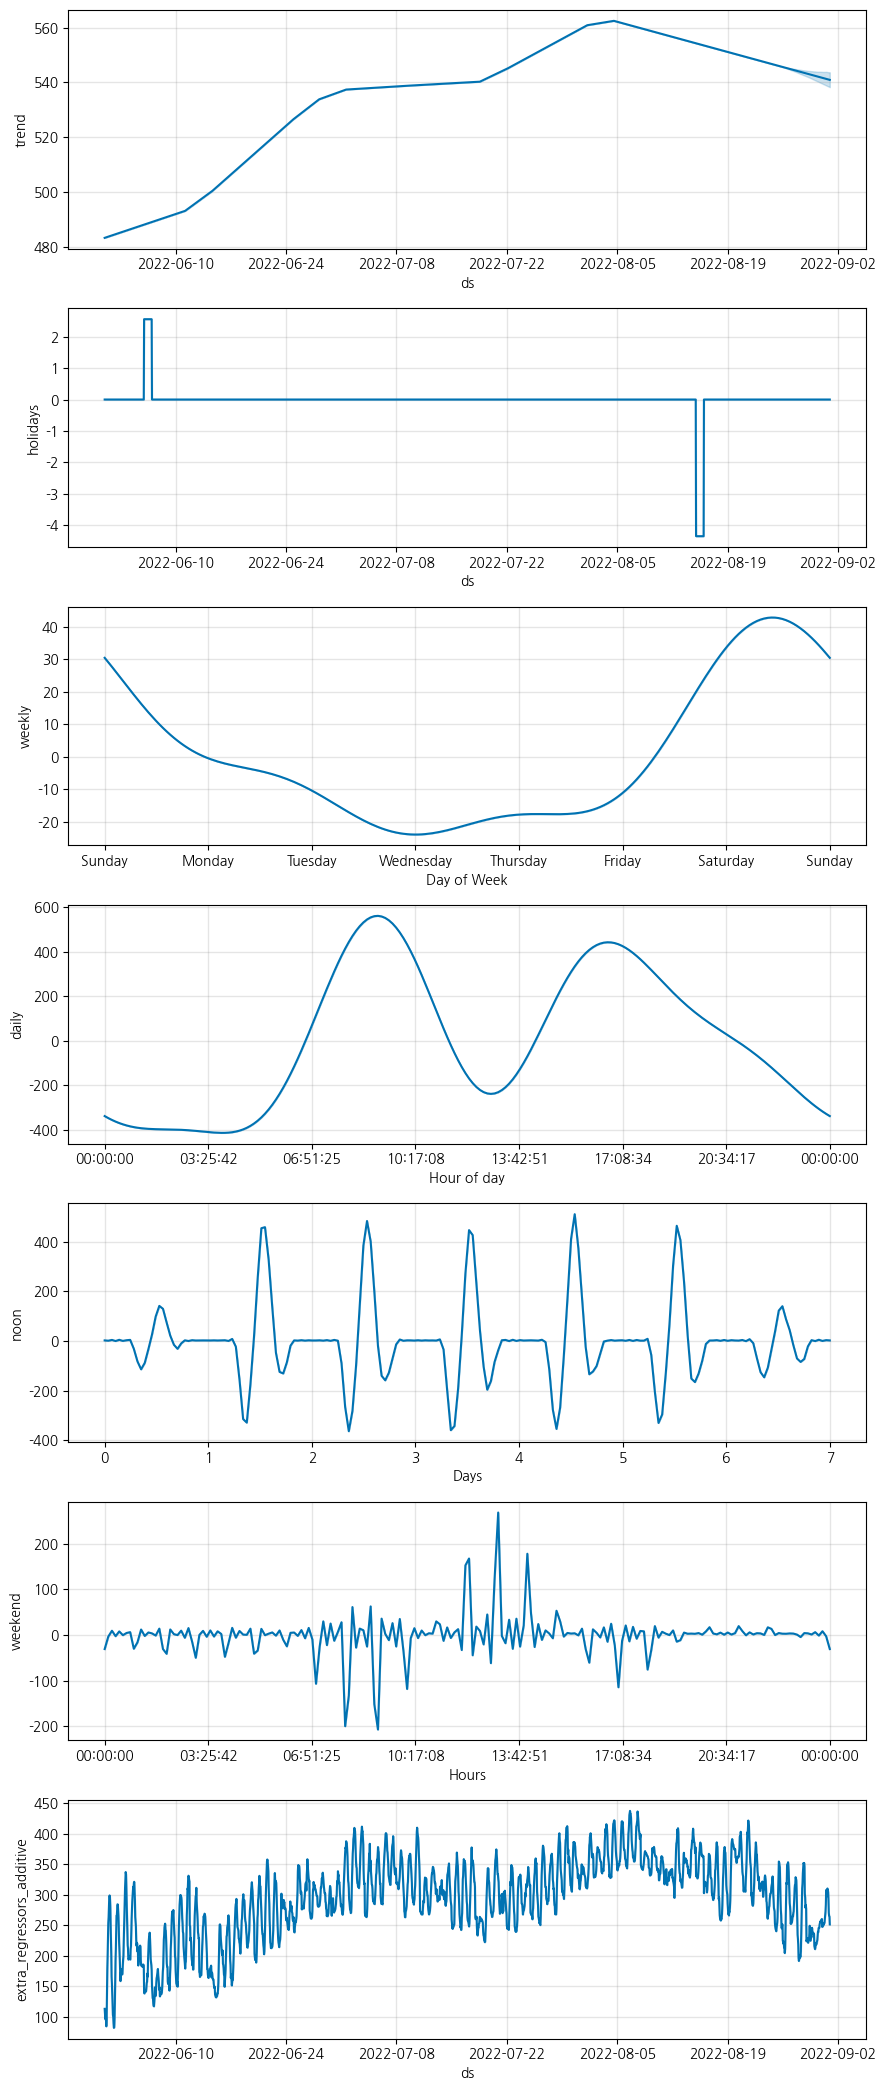

In [32]:
fig = m.plot_components(forecast)

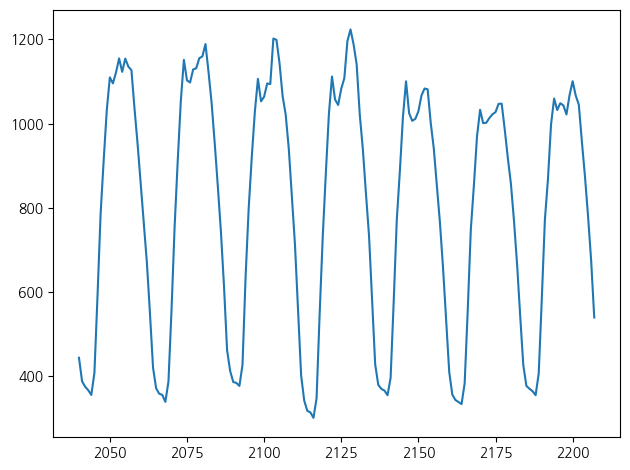

In [33]:
days = 2040
forecast.loc[days:, 'yhat'].plot()
# plt.xticks(ticks=range(0, days+1, 12), labels=forecast['ds'][:days+1:12].dt.strftime('%Y-%m-%d %H:%M'), rotation=45)
plt.tight_layout()
plt.show()

In [34]:
test_submission.to_csv("results/2023-08-19.csv")

## 제출결과
1. cap, floor 설정 및 logistic 분석 실시 : 11.6409051412(2023-08-13.csv)
2. 지난 최고점인 prophet linear모델에 holidays 추가 : 11.3840875952(2023-08-14_h.csv) 점수 상승
3. changepoint_range(과적합 방지용) = 0.95 : 11.3838344125(2023-08-14.csv) 점수 상승
4. changepoint_range(과적합 방지용) = 1 : 11.3809335269(2023-08-15.csv) 점수 상승
5. changepoint_prior_scale = 0.1 : 11.6773858778(2023-08-15_2.csv)
6. changepoint_prior_scale = 0.01 : 11.4329635772(2023-08-15_3.csv)
7. noon, weekend 데이터 추가 : 7.18263(2023-08-15_re.csv) 최고점
8. holidays_prior_scale =  0.0173, changepoint_prior_scale = 0.017 : <b>7.0573028517</b>(2023-08-15_re2.csv)
9. holidays_prior_scale =  0.017, changepoint_prior_scale = 0.017 : 7.0870378211(2023-08-15_re2.csv)